In [ ]:
import torch 
if torch.cuda.device_count() == 4:
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Univariate Regression

The goal is to predict a single scalar output $y \in \mathbb{R}$ from input $x$ using a model $f_\theta(x)$ with parameters $\theta$.

We select the univariate normal, which is defined over $y \in \mathbb{R}$. This distribution has two parameters (mean $\mu$ and variance $\sigma^2$).

$$
p(y|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(y-\mu)^2}{2\sigma^2}\right]
$$

We set the machine learning model to compute the mean.
$$
\mu = f_\theta(x)
$$

We choose a loss function based on the negative log-likelihood.
$$
\begin{align}
L(\theta) & = -\sum_{i=1}^{N}\log p(y_i|f_\theta(x_i), \sigma^2) \\
& = -\sum_{i=1}^{N}\log\left[ \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(y-f_\theta(x_i))^2}{2\sigma^2}\right] \right]
\end{align}
$$

When the train the model, we seek parameters $\hat{\theta}$ that minimize the loss.
$$
\begin{align}
\hat{\theta} & = \underset{\theta}{\mathrm{argmin}}\left[
  -\sum_{i=1}^{N}\log\left[ \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(y-f_\theta(x_i))^2}{2\sigma^2}\right] \right]
  \right] \\
& = \underset{\theta}{\mathrm{argmin}}\left[
  -\sum_{i=1}^{N}
  \left( \log \left[\frac{1}{\sqrt{2\pi\sigma^2}} \right]
  -\frac{(y-f_\theta(x_i))^2}{2\sigma^2} \right) \right]\\
& = \underset{\theta}{\mathrm{argmin}}\left[
  -\sum_{i=1}^{N}
  \left(
  -\frac{(y-f_\theta(x_i))^2}{2\sigma^2} \right) \right]\\
& = \underset{\theta}{\mathrm{argmin}}\left[
  \sum_{i=1}^{N} (y-f_\theta(x_i))^2 \right]\\
\end{align}
$$

Therefore, we have a **least squares loss** function.

$$
L(\theta) = \sum_{i=1}^{N} (y_i-f_\theta(x_i))^2
$$


When we perform inference, we usually want a single "best" point estimate $\hat{y}$, so we take the maximum of the predicted distribution:

$$
\hat{y} = \underset{\theta}{\mathrm{argmax}} \; p(y|f_{\hat{\theta}}(x), \sigma^2)
$$

For the univariate normal, the maximum position is determined by the mean parameter $\mu$. This is precisely what the model computed, so

$$
\hat{y} = f_{\hat{\theta}}(x)
$$

## Mean squared error (MSE)

$$
\text{MSE}(a,b) = \frac{1}{N}\sum_i^N(a_i - b_i)^2
$$

In [ ]:
import torch
from torch import nn

In [ ]:
mse = nn.MSELoss()
a = torch.tensor([1.0, 7.0])
b = torch.tensor([4.0, 2.0])
mse(a, b)

tensor(17.)

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Data

In [ ]:
# Data
# y = 2x + 5
N = 100
x = torch.linspace(-10, 10, N).view(-1, 1)  #(N, 1)
x.shape

torch.Size([100, 1])

In [ ]:
noise = torch.randn_like(x) * 2
y = 2*x + 5 + noise
y.shape

torch.Size([100, 1])

In [ ]:
def y_true(x):
  return 2*x + 5

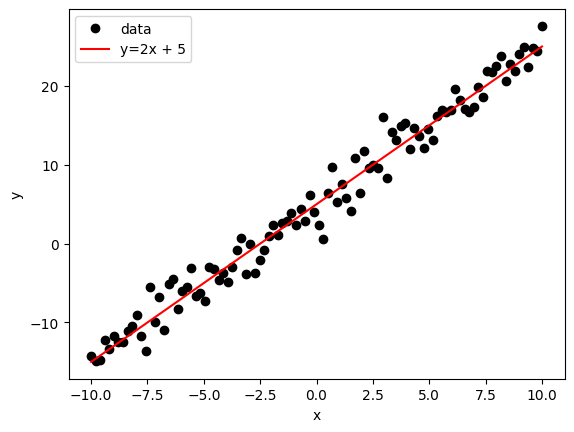

In [ ]:
plt.figure()
plt.plot(x, y, 'o', label='data', color='black')
plt.plot(x, y_true(x), '-', label='y=2x + 5', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Dataset, DataLoader

In [ ]:
class RegressionDataset(Dataset):
    def __init__(self, N=100):
        x = torch.linspace(-10, 10, N).view(-1, 1)
        noise = torch.randn_like(x) * 2
        y = 2*x + 5 + noise
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
dataset = RegressionDataset()
len(dataset)

100

In [ ]:
sample = dataset[0]
sample

(tensor([-10.]), tensor([-12.1419]))

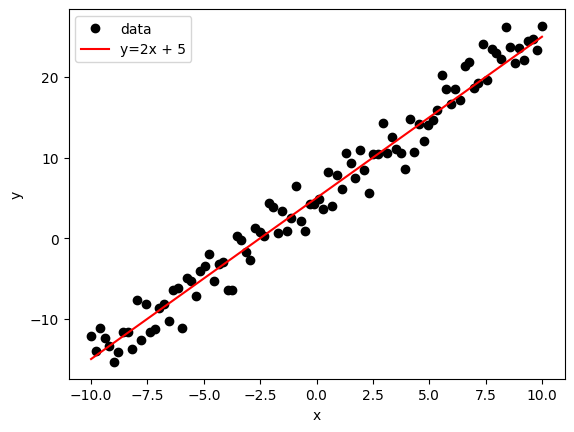

In [ ]:
plt.figure()
plt.plot(dataset.x, dataset.y, 'o', label='data', color='black')
plt.plot(dataset.x, y_true(dataset.x), '-', label='y=2x + 5', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

In [ ]:
for batch in dataloader:
  batch
  break
print(type(batch))
batch

<class 'list'>


[tensor([[-10.0000],
         [ -9.7980]]),
 tensor([[-12.1419],
         [-13.9543]])]

In [ ]:
batch = next(iter(dataloader))
batch

[tensor([[-10.0000],
         [ -9.7980]]),
 tensor([[-12.1419],
         [-13.9543]])]

In [ ]:
dataset[0]

(tensor([-10.]), tensor([-12.1419]))

In [ ]:
dataset[1]

(tensor([-9.7980]), tensor([-13.9543]))

## torch.nn

In [ ]:
layer = nn.Linear(1, 3)
layer

Linear(in_features=1, out_features=3, bias=True)

In [ ]:
inputs = batch[0]
print(inputs)
inputs.shape  # (batch_size, 1)

tensor([[-10.0000],
        [ -9.7980]])


torch.Size([2, 1])

In [ ]:
outputs = layer(inputs)
print(outputs)
outputs.shape  # (batch_size, out_features)

tensor([[-6.3013, -7.2516, -5.0738],
        [-6.1811, -7.0946, -4.9693]], grad_fn=<AddmmBackward0>)


torch.Size([2, 3])

In [ ]:
params = []
for p in layer.parameters():
  print(p, end='\n\n')
  params.append(p.data)

Parameter containing:
tensor([[0.5949],
        [0.7770],
        [0.5170]], requires_grad=True)

Parameter containing:
tensor([-0.3524,  0.5187,  0.0963], requires_grad=True)



In [ ]:
A = params[0]  # weight
A.shape

torch.Size([3, 1])

In [ ]:
b = params[1]  # bias
b.shape

torch.Size([3])

### nn.Linear

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

$$
y = x A^T + b
$$

- $x$: Input $(N, d_\text{in})$
- $A$: Weight matrix $(d_\text{out}, d_\text{in})$
  - $A^T$: Transpose of $A$ $(d_\text{in}, d_\text{out})$
- $b$: Bias $(d_\text{out})$

$$
(N, d_\text{in}) \times (d_\text{in}, d_\text{out}) + (d_\text{out}) \rightarrow (N, d_\text{out})
$$

In [ ]:
# (N, d_out)
intermediate = inputs @ A.T
print(intermediate)
intermediate.shape

tensor([[-5.9489, -7.7703, -5.1700],
        [-5.8287, -7.6133, -5.0656]])


torch.Size([2, 3])

In [ ]:
print(b)
print(b.shape)

tensor([-0.3524,  0.5187,  0.0963])
torch.Size([3])


In [ ]:
print(intermediate[0, :])
print(intermediate[0, :] + b)

tensor([-5.9489, -7.7703, -5.1700])
tensor([-6.3013, -7.2516, -5.0738])


In [ ]:
print(intermediate[1, :])
print(intermediate[1, :] + b)

tensor([-5.8287, -7.6133, -5.0656])
tensor([-6.1811, -7.0946, -4.9693])


In [ ]:
print(outputs)

tensor([[-6.3013, -7.2516, -5.0738],
        [-6.1811, -7.0946, -4.9693]], grad_fn=<AddmmBackward0>)


## Broadcasting

https://numpy.org/doc/stable/user/basics.broadcasting.html

The term broadcasting describes how NumPy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes. Broadcasting provides a means of vectorizing array operations so that looping occurs in C instead of Python. It does this without making needless copies of data and usually leads to efficient algorithm implementations. There are, however, cases where broadcasting is a bad idea because it leads to inefficient use of memory that slows computation.

#### General broadcasting rules
When operating on two arrays, NumPy compares their shapes element-wise. It starts with the trailing (i.e. rightmost) dimension and works its way left. Two dimensions are compatible when

- they are equal, or

- one of them is 1.

If these conditions are not met, a `ValueError: operands could not be broadcast together` exception is thrown, indicating that the arrays have incompatible shapes.

Input arrays do not need to have the same number of dimensions. The resulting array will have the same number of dimensions as the input array with the greatest number of dimensions, where the size of each dimension is the largest size of the corresponding dimension among the input arrays. **Note that missing dimensions are assumed to have size one**.

In [ ]:
# broadcasting
# (N, d_out) + (d_out) =>
# (N, d_out) + (1, d_out) =>
# (N, d_out) + (N, d_out) =>
# (N, d_out)
intermediate = inputs @ A.T
print(intermediate.shape)
print(b.shape)
output_manual = intermediate + b
print(output_manual.shape)

torch.Size([2, 3])
torch.Size([3])
torch.Size([2, 3])


In [ ]:
print(inputs @ A.T + b)
print()
print(layer(inputs))

tensor([[-6.3013, -7.2516, -5.0738],
        [-6.1811, -7.0946, -4.9693]])

tensor([[-6.3013, -7.2516, -5.0738],
        [-6.1811, -7.0946, -4.9693]], grad_fn=<AddmmBackward0>)


## Model

In [ ]:
# Define Model
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Linear(1, 1)

    def forward(self, x):
        return self.model(x)

In [ ]:
inputs

tensor([[-10.0000],
        [ -9.7980]])

In [ ]:
model = RegressionModel()
model(inputs)

tensor([[-0.2422],
        [-0.2450]], grad_fn=<AddmmBackward0>)

In [ ]:
params = []
for p in model.parameters():
  print(p)
  params.append(p.data)

Parameter containing:
tensor([[-0.0143]], requires_grad=True)
Parameter containing:
tensor([-0.3848], requires_grad=True)


In [ ]:
# y = x A^T + b
inputs @ params[0].T + params[1]

tensor([[-0.2422],
        [-0.2450]])

## device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
try:
    model = RegressionModel()
    model.to(device)
    model(inputs)
except Exception as e:
    print(e)

Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)


In [ ]:
model = RegressionModel()
model = model.to(device)
inputs = inputs.to(device)
model(inputs)

tensor([[-5.7785],
        [-5.6745]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Training

In [ ]:
# Initialize model, loss function(criterion), optimizer
model = RegressionModel()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 200
losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Foward propagation
        predictions = model(x)
        loss = criterion(predictions, y)

        # Backpropagation and update weights & biases
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save loss
        train_loss += loss.item()

    train_loss /= len(dataloader)
    losses.append(train_loss)

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch:3d}], Loss: {train_loss:.4f}")

Epoch [  0], Loss: 158.6125
Epoch [ 10], Loss: 31.4738
Epoch [ 20], Loss: 26.5600
Epoch [ 30], Loss: 22.4603
Epoch [ 40], Loss: 19.0993
Epoch [ 50], Loss: 16.3484
Epoch [ 60], Loss: 14.0969
Epoch [ 70], Loss: 12.2542
Epoch [ 80], Loss: 10.7460
Epoch [ 90], Loss: 9.5116
Epoch [100], Loss: 8.5012
Epoch [110], Loss: 7.6742
Epoch [120], Loss: 6.9973
Epoch [130], Loss: 6.4433
Epoch [140], Loss: 5.9898
Epoch [150], Loss: 5.6186
Epoch [160], Loss: 5.3147
Epoch [170], Loss: 5.0660
Epoch [180], Loss: 4.8624
Epoch [190], Loss: 4.6957
Epoch [199], Loss: 4.5717


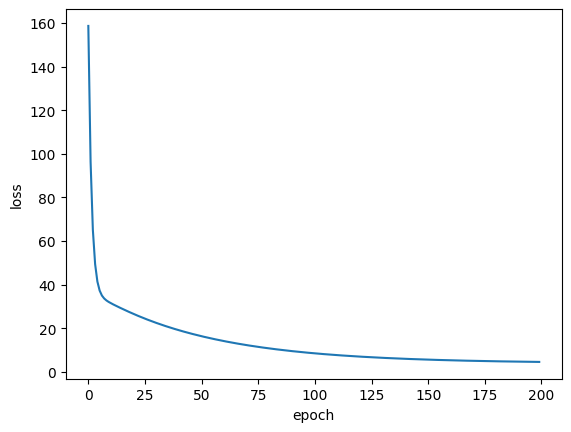

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Inference

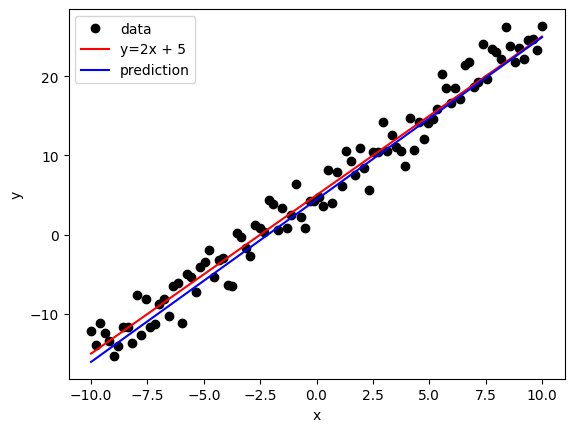

In [ ]:
# with torch.no_grad():
with torch.inference_mode():
    y_pred = model(dataset.x.to(device)).detach().cpu()

plt.figure()
plt.plot(dataset.x, dataset.y, 'o', label='data', color='black')
plt.plot(dataset.x, y_true(dataset.x), '-', label='y=2x + 5', color='red')
plt.plot(dataset.x, y_pred, '-', label='prediction', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
params = []
for p in model.parameters():
  print(p)
  params.append(p.data)

Parameter containing:
tensor([[2.0480]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([4.4319], device='cuda:0', requires_grad=True)


In [ ]:
y_pred_manual = dataset.x.to(device) @ params[0].T + params[1]
y_pred_manual = y_pred_manual.detach().cpu()
torch.allclose(y_pred, y_pred_manual)

True

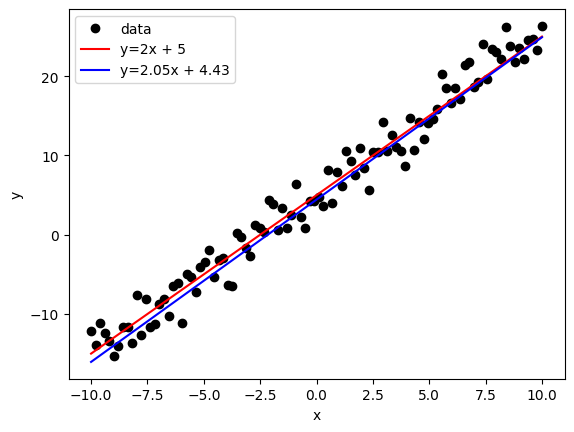

In [ ]:
if params[1].item() > 0:
  label = f'y={params[0].item():.2f}x + {params[1].item():.2f}'
else:
  label = f'y={params[0].item():.2f}x - {abs(params[1].item()):.2f}'

plt.figure()
plt.plot(dataset.x, dataset.y, 'o', label='data', color='black')
plt.plot(dataset.x, y_true(dataset.x), '-', label='y=2x + 5', color='red')
plt.plot(dataset.x, y_pred, '-', label=label, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## Summary

Epoch [  0], Loss: 105.1441
Epoch [ 10], Loss: 22.3004
Epoch [ 20], Loss: 19.0691
Epoch [ 30], Loss: 16.4873
Epoch [ 40], Loss: 14.3490
Epoch [ 50], Loss: 12.6278
Epoch [ 60], Loss: 11.1988
Epoch [ 70], Loss: 10.0501
Epoch [ 80], Loss: 9.0917
Epoch [ 90], Loss: 8.3152
Epoch [100], Loss: 7.6847
Epoch [110], Loss: 7.1532
Epoch [120], Loss: 6.7322
Epoch [130], Loss: 6.3707
Epoch [140], Loss: 6.0971
Epoch [150], Loss: 5.8658
Epoch [160], Loss: 5.6683
Epoch [170], Loss: 5.5130
Epoch [180], Loss: 5.3884
Epoch [190], Loss: 5.2792
Epoch [199], Loss: 5.2029


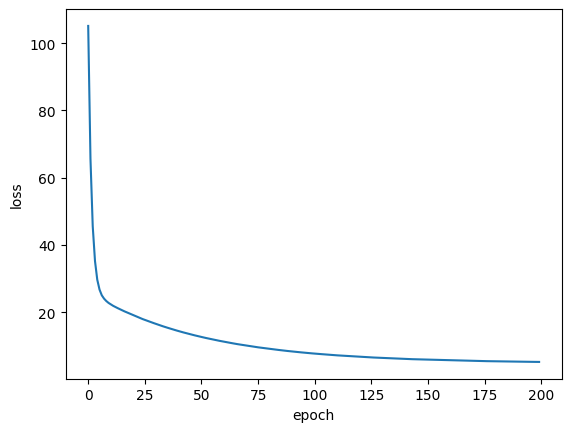

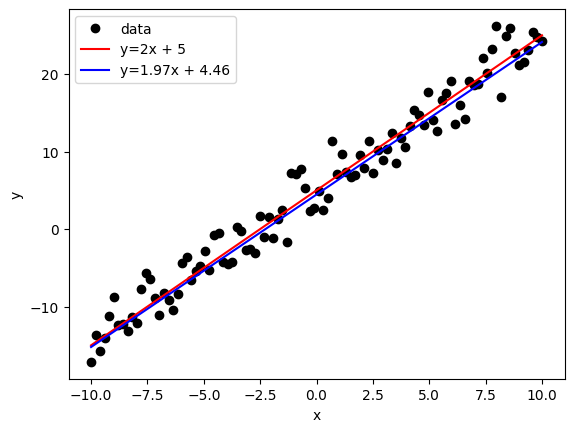

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define Dataset
class RegressionDataset(Dataset):
    def __init__(self, N=100):
        x = torch.linspace(-10, 10, N).view(-1, 1)
        noise = torch.randn_like(x) * 2
        y = 2*x + 5 + noise
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Define Model
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Linear(1, 1)

    def forward(self, x):
        return self.model(x)

# Dataset, DataLoader
dataset = RegressionDataset()
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Model, Optimizer, Criterion
model = RegressionModel()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 200
losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    for batch in dataloader:
        x, y = batch

        # Foward propagation
        predictions = model(x)
        loss = criterion(predictions, y)

        # Backpropagation and update weights & biases
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save loss
        train_loss += loss.item()

    train_loss /= len(dataloader)
    losses.append(train_loss)

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch:3d}], Loss: {train_loss:.4f}")

# Loss curve
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Inference
def get_label(model):
    params = []
    for p in model.parameters():
        params.append(p.data)
    if params[1].item() > 0:
      label = f'y={params[0].item():.2f}x + {params[1].item():.2f}'
    else:
      label = f'y={params[0].item():.2f}x - {abs(params[1].item()):.2f}'
    return label

with torch.inference_mode():
    y_pred = model(dataset.x)

label = get_label(model)

plt.figure()
plt.plot(dataset.x, dataset.y, 'o', label='data', color='black')
plt.plot(dataset.x, y_true(dataset.x), '-', label='y=2x + 5', color='red')
plt.plot(dataset.x, y_pred, '-', label=label, color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()